# Results Analysis
Afer completing the training for the DQN Pong, I read in the mp4 and csv files as well as the checkpoint in order to better understand the results

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import ffmpeg
import os
import random
import gym

from dqn.agent import DQNAgent
from dqn.replay_buffer import ReplayBuffer
from dqn.wrappers import *
import torch
import argparse

In [3]:
results = pd.read_csv("rewards.csv", names=["Rewards"])
results['Episode'] = results.index
results.head()

,Rewards,Episode
0,-20.0,0
1,-20.0,1
2,-21.0,2
3,-21.0,3
4,-21.0,4


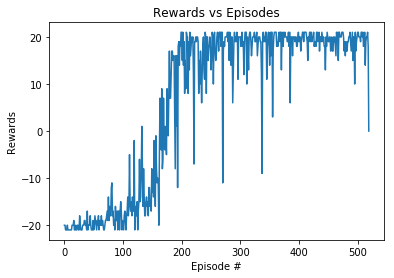

In [12]:
plt.plot(results.Episode, results.Rewards)
plt.title("Rewards vs Episodes")
plt.xlabel("Episode #")
plt.ylabel("Rewards")
plt.savefig("submission/plot.png")
plt.show()

In [5]:
stream = ffmpeg.input('500eps.mp4')
ffmpeg.output(stream, '500eps.gif').run()

(None, None)

In [14]:
eps_start= 0.01
hyper_params = {
    "seed": 42,
    "env": "PongNoFrameskip-v4",
    "replay-buffer-size": int(5e3),
    "learning-rate": 1e-4,
    "discount-factor": 0.99,
    "num-steps": int(1e6),
    "batch-size": 32,
    "learning-starts": 10000,
    "learning-freq": 1,
    "use-double-dqn": True, 
    "target-update-freq": 1000, 
    "eps-start": eps_start, 
    "eps-end": 0.01,
    "eps-fraction": 0.1,
    "print-freq": 10
}

np.random.seed(hyper_params["seed"])
random.seed(hyper_params["seed"])
env = gym.make(hyper_params["env"])
env.seed(hyper_params["seed"])

env = NoopResetEnv(env, noop_max=30)
env = MaxAndSkipEnv(env, skip=4)
env = EpisodicLifeEnv(env)
env = FireResetEnv(env)
env = WarpFrame(env)
env = PyTorchFrame(env)
env = ClipRewardEnv(env)
env = FrameStack(env, 4)

replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])

agent = DQNAgent(
    env.observation_space,
    env.action_space,
    replay_buffer,
    use_double_dqn=hyper_params["use-double-dqn"],
    lr=hyper_params['learning-rate'],
    batch_size=hyper_params['batch-size'],
    gamma=hyper_params['discount-factor'],
)

agent.policy_network.load_state_dict(torch.load("checkpoints/checkpoint.pth"))

eps_timesteps = hyper_params["eps-fraction"] * \
    float(hyper_params["num-steps"])
episode_rewards = []
env = gym.wrappers.Monitor(env,'./submission/',force=True)
state = env.reset()
done = False
while not done:
    next_state, _, done, _ = env.step(agent.act(state))
    state = next_state
    env.render()
env.close()

In [20]:
vid_loc = ""
for file in os.listdir("./submission"):
    if file.endswith(".mp4"):
        vid_loc = os.path.join("./submission", file)

In [21]:
stream = ffmpeg.input(vid_loc)
stream = ffmpeg.output(stream, './submission/final_vid.gif').run()

(None, None)